# Cálculo Numérico - Interpolação polinomial

**Professor**: Luiz Gustavo Cordeiro

A biblioteca [NumPy](numpy.org) permite manipular matrizes e fazer várias operações típicas da disciplina de Cálculo Numérico. A biblioteca [Matplotlib](matplotlib.org) permite criar gráficos e imagens.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Implementação de interpolação polinomial resolvendo um sistema linear

Vamos criar um conjunto de dados a ser interpolado. Lembre-se de que um conjunto com $n+1$ pontos é interpolado por uma polinomial de grau $n$. Vamos começar com um valor pequeno de $n$.

In [2]:
n = 5

Por simplicidade, vamos escolher as coordenadas $x$ dos nós sobre os quais interpolamos como sendo
$$x_0=0,\quad x_1=1,\quad \ldots,x_n=n.$$

In [3]:
x = np.array(range(n+1)).astype(float)

As coordenadas $y$ dos nós serão escolhida aleatoriamente no intervalor $[-10,10]$.

In [4]:
y = 20*np.random.rand(n+1)-10 # Escolha de números aleatórios entre -10 e 10

In [5]:
print("x = ",x,end="")
print("\ny = ",y,end="")

x =  [0. 1. 2. 3. 4. 5.]
y =  [-9.80197265  3.48553076  2.56937444  4.62189097 -3.57110474  8.67279241]

Podemos plotar o conjunto de dados $(x,y)$, só para ter ideia de como ele está distribuído.

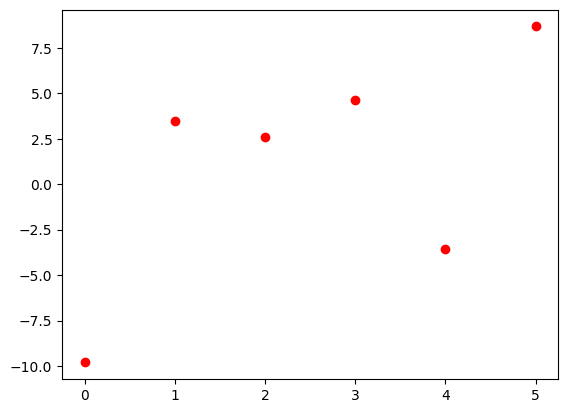

In [6]:
plt.plot(x,y,'ro')

Agora, vamos calcular a função polinomial que interpola esses pontos, conforme visto em aula. O primeiro passo é criar a matriz de Vandermonde. Isso pode ser feito explicitamente (inicializando a matriz e calculando termo-a-termo) ou utilizando uma função própria Numpy, que cria matrizes de Vandermonde:  [`Numpy.vander()`](https://numpy.org/doc/stable/reference/generated/numpy.vander.html).

Em geral, as funções já definidas no Numpy são altamente otimizadas (às vezes até chamando comandos de linguagens de mais baixo nível). Vamos comparar o tempo de execução de três modos abaixo:

In [7]:
%%timeit
# Definindo a matriz de Vandermonde de modo explítico e "ingenuo"
M = np.zeros((n+1,n+1))

for i in range(n+1):
    for j in range(n+1):
        M[i,j]=x[i]**j

104 µs ± 17.8 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [8]:
%%timeit
# Definindo a matriz de Vandermonde de modo explícito e otimizado
M = np.zeros((n+1,n+1))

for i in range(n+1):
    p=1
    for j in range(n+1):
        M[i,j] = p
        p*=x[j]

45.3 µs ± 12.3 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [9]:
%%timeit
# Usando a função do Numpy
M = np.vander(x,increasing=True)

12.7 µs ± 2.26 µs per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


O último modo foi o melhor.

In [10]:
M = np.vander(x,increasing=True)

Agora, precisamos resolver o sistema linear $Ma=y$. A função [`numpy.linalg.solve()`](https://numpy.org/doc/stable/reference/generated/numpy.linalg.solve.html) faz o trabalho pesado.

In [11]:
a = np.linalg.solve(M,y)

A lista $a=[a_0,a_1,\ldots,a_n]$ possui os coeficientes da polinomial
$$p(x)=a_0+a_1x+\cdots+a_nx^n$$
que interpola o conjunto de dados.

Vamos definir a função polinomial, que é avaliada pelo método de Horner para ser mais eficiente:

In [12]:
def p(t):
    r = a[n]
    for i in range(n-1,-1,-1):
        r = a[i] + t*r
    return r

Agora, vamos plotar a nossa função polinomial contra o conjunto de dados.

In [13]:
dom = np.linspace(np.min(x),np.max(x),1000)
im = [p(t) for t in dom]

(-12.0, 12.0)

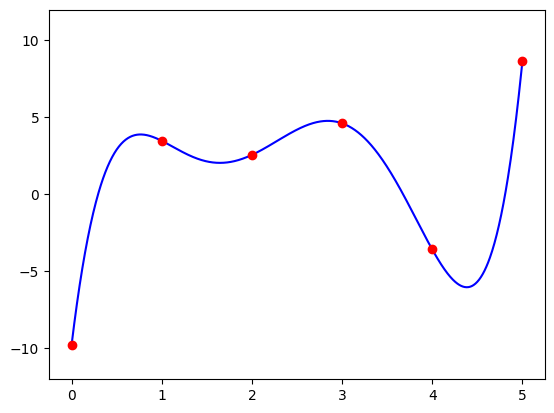

In [14]:
plt.plot(dom,im,'b')
plt.plot(x,y,'ro')
plt.ylim(-12,12)

O resultado obtido foi o esperado.

## Implementação da interpolação de Lagrange

Alternativamente, vamos implementar o método da Interpolação de Lagrange, que não necessita resolver um sistema linear.

In [15]:
def q(t):
    soma = 0
    for i in range(n+1):
        produ = 1
        for j in range(n+1):
            if j!= i: produ *= (t-x[j])/(x[i]-x[j])
            
        soma += y[i]*produ
    
    return soma

Vamos plotar $q$ no mesmo domínio e compara com o conjunto de dados.

In [16]:
dom_q = dom
im_q = [q(t) for t in dom_q]

(-12.0, 12.0)

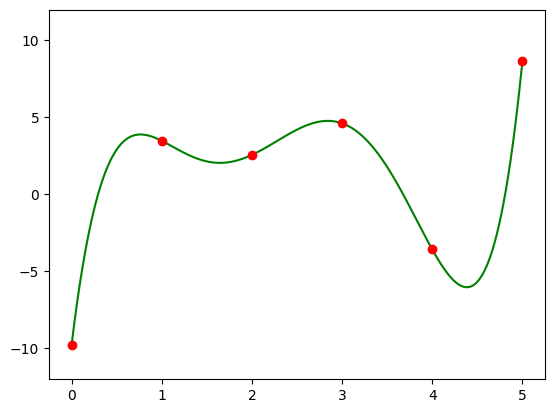

In [17]:
plt.plot(dom_q,im_q,'g')
plt.plot(x,y,'ro')
plt.ylim(-12,12)

O resultado deu o mesmo que o anterior.

## Comparação entre os métodos de interpolação.

Se quisermos calcular a função interpoladora em um único ponto, normalmente é mais rápido aplicar a fórmula da interpolação de Lagrange, pois para aplicar o método envolvendo o sistema linear temos antes que tudo *resolver* um sistema linear. Isso toma tempo. **Porém**, a função `numpy.linalg.solve()` chama uma subrotina em FORTRAN altamente otimizada, que faz com que a resolução do sistema linear fique muito mais rápida do que seria permitido fazendo-se todo o programa em Python. Assim, não podemos atualmente comparar esses dois métodos de modo justo, pois precisamos de uma rotina de resolução de sistemas lineares em Python, que só será vista mais à frente na disciplina.

Por outro lado, podemos verificar que várias avaliações das polinomiais obtidas resolvendo-se o sistema linear e por interpolação de Lagrange realmente fazem com que o primeiro método seja de fato mais eficiente.

In [18]:
%%timeit

[p(t) for t in dom]

3.69 ms ± 530 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [19]:
%%timeit

[q(t) for t in dom]

43.7 ms ± 4.44 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


## Interpolação de dados por polinomiais de grau alto

Em geral, interpolação polinomial só é um processo [estável numericamente](https://en.wikipedia.org/wiki/Numerical_stability) para polinômios de grau baixo (via de regra, $\leq 5$). Se aplicarmos os mesmos métodos que acima para um conjunto de dados com 20 pontos, há uma chance de ocorrer o [Fenômeno de Runge](https://en.wikipedia.org/wiki/Runge%27s_phenomenon), e/ou até que a interpolação não seja de fato obtida. Isso ocorre principalmente pois as ordens de grandeza de uma matriz de Vandermonde podem variar muito dependendo do seu tamanho.

In [20]:
n=20

x = np.array(range(n+1)).astype(float)
y = 20*np.random.rand(n+1)-10 # Escolha de números aleatórios entre -10 e 10

M = np.vander(x,increasing=True)
print("A matriz de Vandermonde que determina o sistema linear tem\n"+\
    "valores maximo e minimo (em modulo)" , np.min(np.abs(M)) , "e" , np.max(np.abs(M)))
a = np.linalg.solve(M,y)

def p(t):
    r = a[n]
    for i in range(n-1,-1,-1):
        r = a[i] + t*r
    return r

dom = np.linspace(np.min(x),np.max(x),1000)
im = [p(t) for t in dom]

A matriz de Vandermonde que determina o sistema linear tem
valores maximo e minimo (em modulo) 0.0 e 1.048576e+26


Text(0.5, 1.0, 'Plot em escala\nFenômeno de Runge')

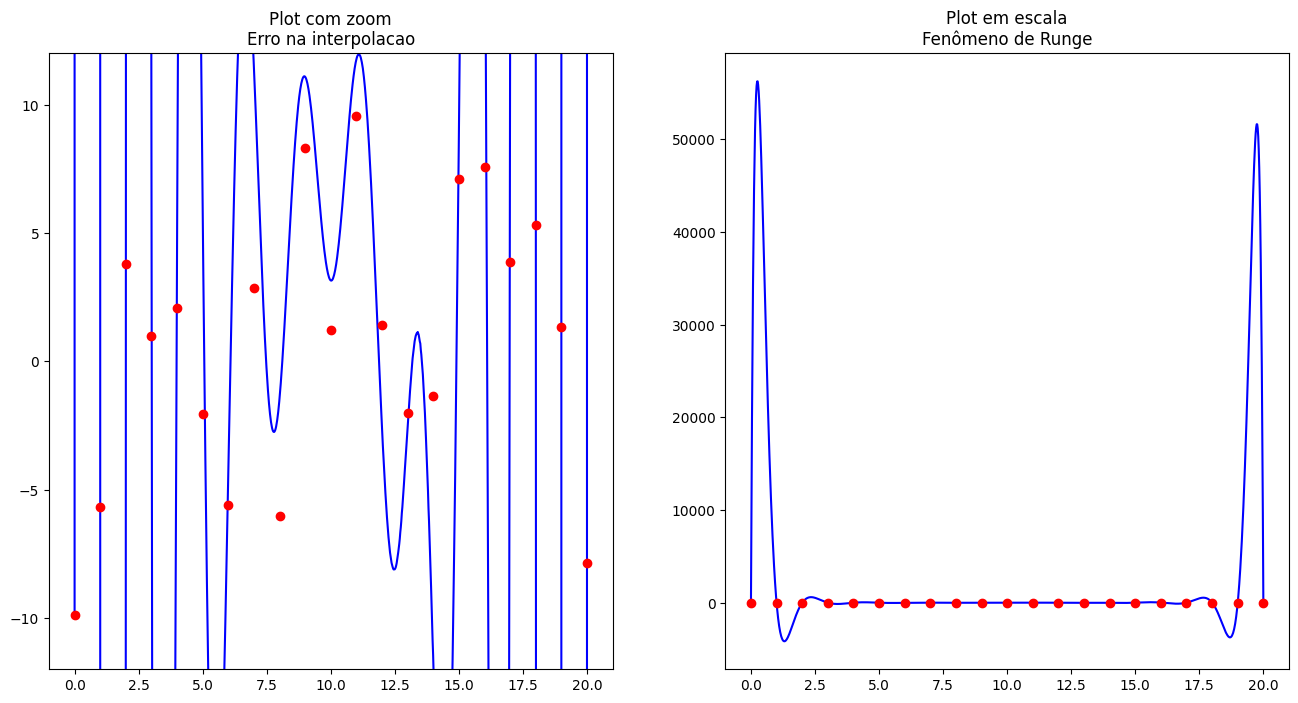

In [21]:
fig , axs = plt.subplots(1,2,figsize=(16,8))

axs[0].plot(dom,im,'b')
axs[0].plot(x,y,'ro')
axs[0].set_ylim(-12,12)
axs[0].set_title("Plot com zoom\nErro na interpolacao")

axs[1].plot(dom,im,'b')
axs[1].plot(x,y,'ro')
axs[1].set_title("Plot em escala\nFenômeno de Runge")